# Imports

In [1]:
import pickle
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

%matplotlib inline

In [2]:
run_id = 0

In [3]:
with open('ros_packages/px4_ros_extended/src_py/params.yaml') as info:
    info_dict = yaml.load(info, Loader=yaml.SafeLoader)
        
n_test = info_dict["test_window_reward"]
n_train = info_dict["train_window_reward"]

# Dataframe Creation

In [4]:
with open("logs/log_" + str(run_id) + ".pkl", "rb") as file_pkl:
    data = pickle.load(file_pkl)
train = pd.Series(data[0])
test = pd.Series(data[1])

# Reward Visualization

([<matplotlib.axis.XTick at 0x7f8268e4cac0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

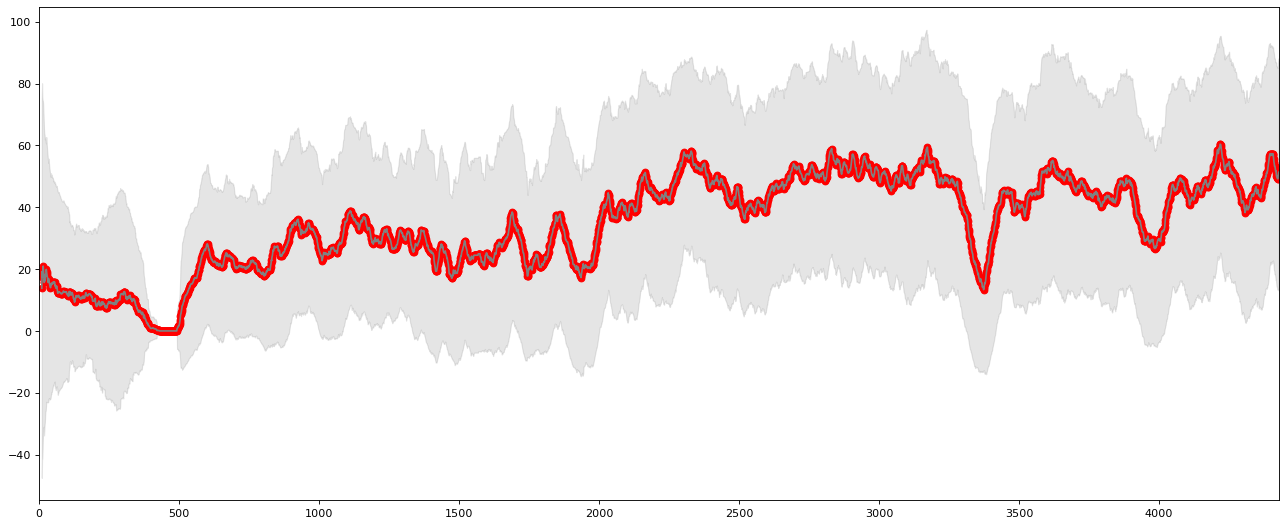

In [5]:
# Visualize the result
means = train.rolling(n_train, min_periods=10).mean().values
stds = train.rolling(n_train, min_periods=10).std().values
x = range(0, len(means))
figure(figsize=(20, 8), dpi=80)

# Convert range object to a list
x = list(x)

plt.plot(x, means, 'or')
plt.plot(x, means, '-', color='gray')

plt.fill_between(x, means - stds, means + stds, color='gray', alpha=0.2)
plt.xlim(0, len(means)+1)
plt.xticks(ticks=range(0, len(means), 500))



In [6]:
# # Visualize the result
# means = train.rolling(n_train, min_periods=10).mean()
# stds = train.rolling(n_train, min_periods=10).std()
# x = range(0, len(means))
# figure(figsize=(20, 8), dpi=80)
# plt.plot(x, means, 'or')
# plt.plot(x, means, '-', color='gray')

# plt.fill_between(x, means - stds, means + stds,
#                  color='gray', alpha=0.2)
# plt.xlim(0, len(means)+1)
# plt.xticks(ticks=range(0, len(means), 500))

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (8).

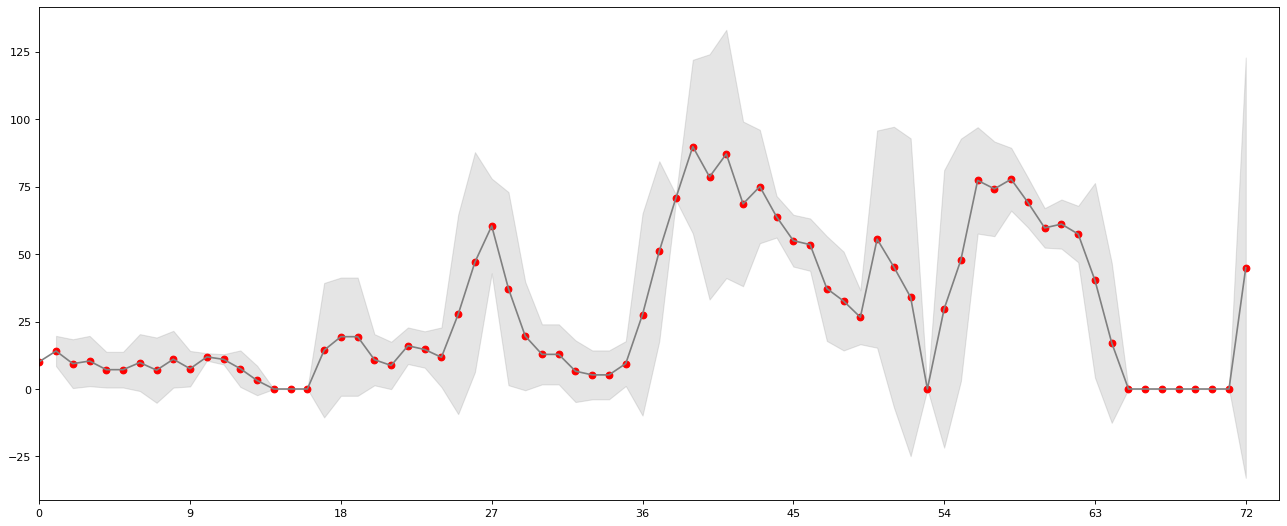

In [7]:
# Visualize the result
means = test.rolling(n_test, min_periods=1).mean().values
stds = test.rolling(n_test, min_periods=1).std().values
x = range(0, len(means))
figure(figsize=(20, 8), dpi=80)

# Convert range object to a list
x = list(x)

plt.plot(x, means, 'or')
plt.plot(x, means, '-', color='gray')

plt.fill_between(x, means - stds, means + stds, color='gray', alpha=0.2)
plt.xlim(0, len(means)+1)
plt.xticks(ticks=range(0, len(means), 9), labels=range(500, int(len(means)/9)*500 + 500, 500))


In [8]:
# means = test.rolling(n_test, min_periods=1).mean()
# stds = test.rolling(n_test, min_periods=1).std()
# x = range(0, len(means))
# figure(figsize=(20, 8), dpi=80)
# plt.plot(x, means, 'or')
# plt.plot(x, means, '-', color='gray')

# plt.fill_between(x, means - stds, means + stds,
#                  color='gray', alpha=0.2)
# plt.xlim(0, len(means)+1);
# plt.xticks(ticks=range(0, len(means), 9), labels=range(500, int(len(means)/9)*500 + 500, 500));

In [9]:
test.groupby(test.index // 9).mean()

0      9.195771
1      8.458112
2     24.172368
3     11.882411
4     73.939890
5     30.917137
6     67.936574
7      0.000000
8    134.863880
dtype: float64

# Test Results Visualization

In [10]:
folder_path = "test_logs/" + str(run_id)
file_list = os.listdir(folder_path)

## Statistics

In [11]:
last_pos = []  # List of last positions
last_vel = []  # List of last velocities
cont_steps = 0  # Count number of steps
for file in file_list:
    with open(folder_path + "/" + file, "rb") as file_pkl:
        data = pickle.load(file_pkl)
    cont_steps += len(data[0]['x'])
    last_pos.append([np.abs(data[0]['x'][-1]), np.abs(data[0]['y'][-1]), np.abs(data[0]['z'][-1])])
    if len(data[1]) == 2:
        last_vel.append([np.abs(data[1]['vx'][-1]), np.abs(data[1]['vy'][-1])])
    elif len(data[1]) == 3:
        last_vel.append([np.abs(data[1]['vx'][-1]), np.abs(data[1]['vy'][-1]), np.abs(data[1]['vz'][-1])])
        last_pos[-1].append(data[1]['vz'][-1])  # Used to deal with ground not at z=0
last_pos = np.array(last_pos)
last_vel = np.array(last_vel)

success_cont = 0
for i in range(len(last_pos)):
    if last_pos[i][0] <= 0.3 and last_pos[i][1] <= 0.3:
        success_cont += 1
        if len(data[1]) == 3 and last_pos[i][3] > 0.1:  # Checking also vz, if available
            success_cont -= 1
sr = 100 * success_cont / len(last_pos)

print("Success Rate: {}".format(sr))
print("Average number of steps: ", cont_steps / len(last_pos))

print("Mean distance from target: ({}, {}, {})".format(last_pos[:, 0].mean(), last_pos[:, 1].mean(), last_pos[:, 2].mean()))
print("Std distance from target: ({}, {}, {})".format(last_pos[:, 0].std(), last_pos[:, 1].std(), last_pos[:, 2].std()))
print("Max distance from target: ({}, {}, {})".format(last_pos[:, 0].max(), last_pos[:, 1].max(), last_pos[:, 2].max()))
print("90% percentile distance from target: ({}, {}, {})".format(np.percentile(last_pos[:, 0], 90), np.percentile(last_pos[:, 1], 90), np.percentile(last_pos[:, 2], 90)))
print()
if len(last_vel[0])==2:
    print("Mean velocity: ({}, {})".format(last_vel[:, 0].mean(), last_vel[:, 1].mean()))
    print("Std velocity: ({}, {})".format(last_vel[:, 0].std(), last_vel[:, 1].std()))
    print("Max velocity: ({}, {})".format(last_vel[:, 0].max(), last_vel[:, 1].max()))
    print("90% percentile velocity: ({}, {})".format(np.percentile(last_vel[:, 0], 90), np.percentile(last_vel[:, 1], 90)))
elif len(last_vel[0])==3:
    print("Mean velocity: ({}, {}, {})".format(last_vel[:, 0].mean(), last_vel[:, 1].mean(), last_vel[:, 2].mean()))
    print("Std velocity: ({}, {}, {})".format(last_vel[:, 0].std(), last_vel[:, 1].std(), last_vel[:, 2].std()))
    print("Max velocity: ({}, {}, {})".format(last_vel[:, 0].max(), last_vel[:, 1].max(), last_vel[:, 2].max()))
    print("90% percentile velocity: ({}, {}, {})".format(np.percentile(last_vel[:, 0], 90), np.percentile(last_vel[:, 1], 90), np.percentile(last_vel[:, 2], 90)))

Success Rate: 2.1739130434782608
Average number of steps:  11.434782608695652
Mean distance from target: (0.4292106632718678, 0.48126250521363684, 0.05226626245051609)
Std distance from target: (0.22750414350649364, 0.2305478121646826, 0.006710056618160139)
Max distance from target: (0.8280579526587519, 1.3310616321542008, 0.07186111324052277)
90% percentile distance from target: (0.6998830888120415, 0.7241045967713284, 0.059653573416765235)

Mean velocity: (0.23356201502830884, 0.38521153882775433, 0.0993060065822263)
Std velocity: (0.14290360028810217, 0.2908397070919787, 0.12518666682616394)
Max velocity: (0.8825321267263616, 1.0364048717538166, 0.592235514554386)
90% percentile velocity: (0.3896150799821937, 0.9198080555617766, 0.22930016780502463)


## Position & Velocity over time, single episode

In [12]:
with open(folder_path + "/" + file_list[1], "rb") as file_pkl:
    data = pickle.load(file_pkl)
positions = pd.DataFrame(data[0])
velocities = pd.DataFrame(data[1])
velocities_ref = -pd.DataFrame(data[2])
time = data[3]

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (10).

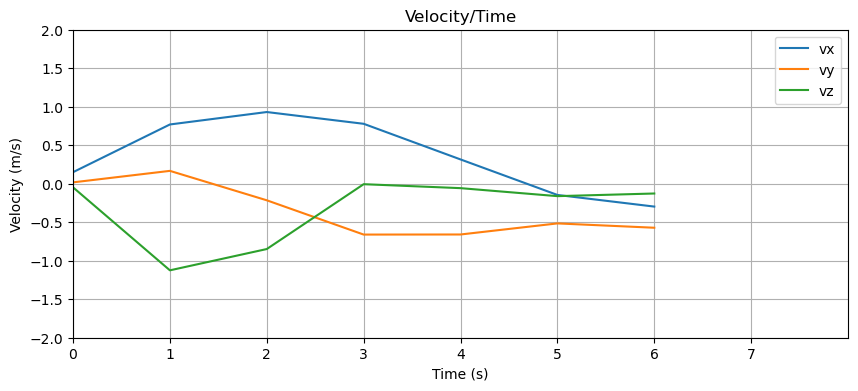

In [13]:
ax = velocities.plot(title="Velocity/Time", figsize=(10, 4));
plt.ylim(-2, 2);
plt.xlim(0, len(velocities)+1);
plt.grid();
ax.set_xlabel("Time (s)");
ax.set_ylabel("Velocity (m/s)");
v_t = round(len(velocities)/time)
vel_list = list(range(0, len(velocities), v_t))
time_list = list(range(0, round(time), 1))
if len(vel_list) > len(time_list):
    time_list = list(range(0, round(time)+1, 1))
elif len(time_list) > len(vel_list):
    vel_list = list(range(0, len(velocities)+v_t, v_t))
plt.xticks(ticks=vel_list , labels=time_list);

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (10).

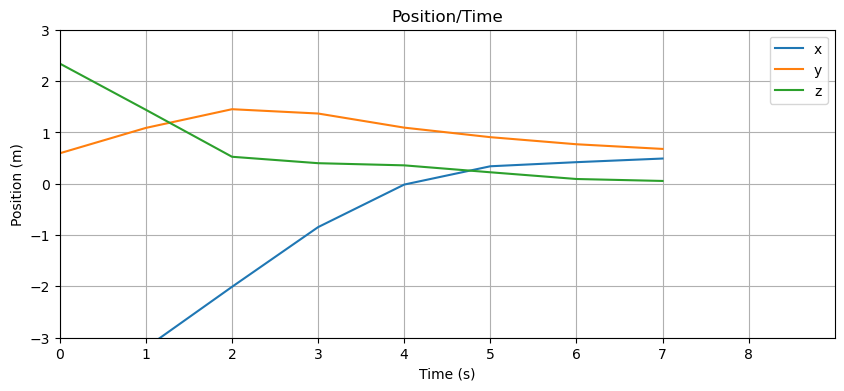

In [14]:
ax = positions.plot(title="Position/Time", figsize=(10, 4));
plt.ylim(-3, 3);
plt.xlim(0, len(positions)+1);
plt.grid();
ax.set_xlabel("Time (s)");
ax.set_ylabel("Position (m)");
p_t = round(len(positions)/time)+1
pos_list = list(range(0, len(positions), v_t))
time_list = list(range(0, round(time), 1))
if len(pos_list) > len(time_list):
    time_list = list(range(0, round(time)+1, 1))
elif len(time_list) > len(pos_list):
    pos_list = list(range(0, len(positions)+v_t, v_t))
plt.xticks(ticks=pos_list , labels=time_list);

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (10).

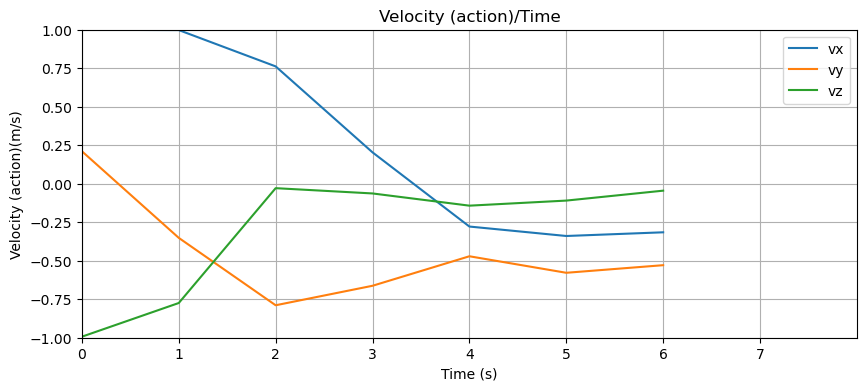

In [15]:
ax = velocities_ref.plot(title="Velocity (action)/Time", figsize=(10, 4));
plt.ylim(-1, 1);
plt.xlim(0, len(velocities_ref)+1);
plt.grid();
ax.set_xlabel("Time (s)");
ax.set_ylabel("Velocity (action)(m/s)");
v_t = round(len(velocities_ref)/time)
vel_list = list(range(0, len(velocities_ref), v_t))
time_list = list(range(0, round(time), 1))
if len(vel_list) > len(time_list):
    time_list = list(range(0, round(time)+1, 1))
elif len(time_list) > len(vel_list):
    vel_list = list(range(0, len(velocities_ref)+v_t, v_t))
plt.xticks(ticks=vel_list , labels=time_list);